In [8]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

from pathlib import Path
from node2vec import Node2Vec
from sklearn.manifold import TSNE
from sklearn.cluster  import KMeans
from utils.load_data import load_all_data

In [2]:
def create_sliding_window_dataset(data, window_size, horizon):

    """
    Создает датасет из скользящего окна для временных рядов.

    :param data: Исходный временной ряд (одномерный массив).
    :param window_size: Размер окна для входных данных (X).
    :param horizon: Размер горизонта для целевых значений (y).
    :return: Кортеж (X, y), где X — входные данные, y — целевые значения.
    """
    X, y = [], []
    for i in range(len(data) - window_size - horizon + 1):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size:i + window_size + horizon])
    return np.array(X), np.array(y)

def replace_zeros_with_rolling_mean(data, window=3):
    df = pd.DataFrame(data)
    df_filled = df.copy()
    rolling_mean = df.rolling(window=window, min_periods=1).mean()
    df_filled[df == 0] = rolling_mean[df == 0]
    return df_filled.values

In [ ]:
data_dir = Path('../data/PEMS-BAY')
metadata, data, adj = load_all_data(data_dir)

print(f"Shape of data: {data.shape}")

In [ ]:
G = nx.from_numpy_array(adj)
node2vec = Node2Vec(G, dimensions=64, walk_length=30, num_walks=200, p=1, q=1, workers=12)
model = node2vec.fit(window=10, min_count=1, batch_words=4)
node_embeddings = {node: model.wv[str(node)] for node in G.nodes()}


d:\programming\github\traffic_prediction_model\.venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


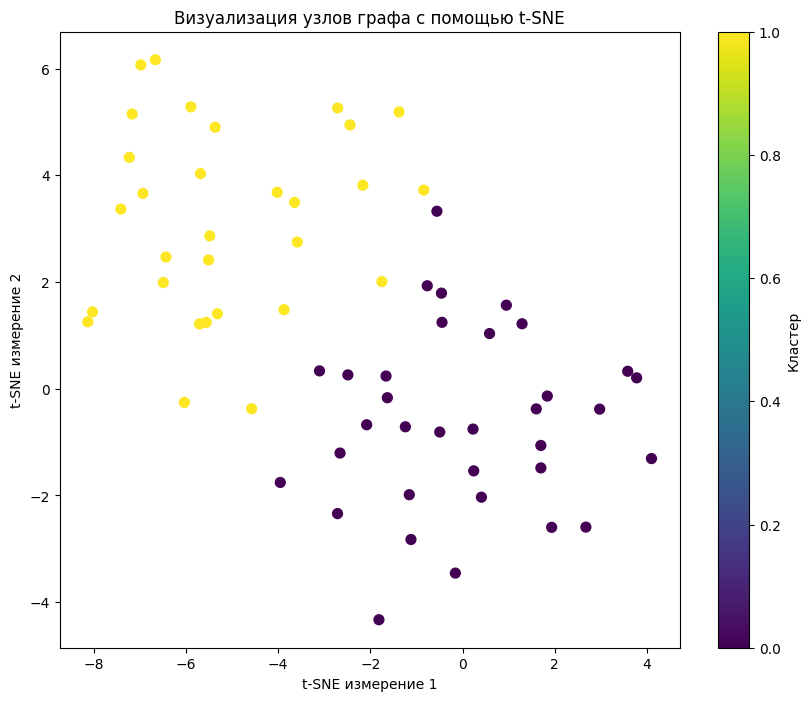

In [27]:
node_embeddings_df = pd.DataFrame(node_embeddings)
tsne = TSNE(n_components=2, random_state=42, perplexity=20, n_iter=1000)
embeddings_2d = tsne.fit_transform(node_embeddings_df)

kmeans = KMeans(n_clusters=2, random_state=42)  # Задайте количество кластеров
clusters = kmeans.fit_predict(node_embeddings_df)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=clusters, cmap='viridis', s=50)
plt.colorbar(scatter, label='Кластер')
plt.title('Визуализация узлов графа с помощью t-SNE')
plt.xlabel('t-SNE измерение 1')
plt.ylabel('t-SNE измерение 2')
plt.show()